c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


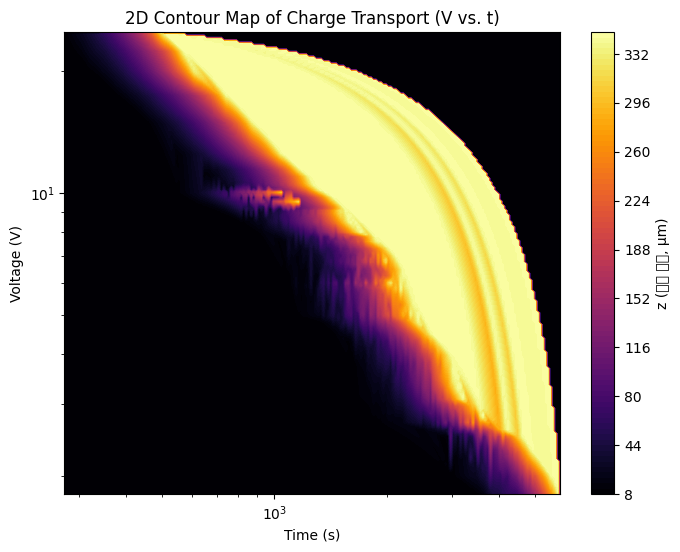

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
from glob import glob

# 이동평균 필터 함수
def moving_average(data, window_size=5):
    return pd.Series(data).rolling(window=window_size, center=True, min_periods=1).mean().values

# 데이터 디렉토리 설정
data_dir = "."  # 실제 경로로 변경
file_list = sorted(glob(os.path.join(data_dir, "*.dat")))

t_values = []  # 시간 데이터
V_values = []  # 전압 데이터
z_values = []  # 거리 데이터

for file_path in file_list:
    # 파일명에서 V 값 추출
    try:
        V_value = float(os.path.basename(file_path).split("V")[0])
    except ValueError:
        continue  # 파일명에서 숫자 추출 실패 시 건너뛰기

    if V_value < 1.8:  # 1.8V 미만 데이터 무시
        continue
    
    df = pd.read_csv(file_path, sep=',', header=None, names=["z", "t"])
    df["z"] = 400 - df["z"]  # z를 400-z로 변환
    
    df = df.groupby("t").mean().reset_index()  # 중복된 t값 평균 처리
    
    t_values.extend(df["t"].values)
    V_values.extend([V_value] * len(df))
    z_values.extend(moving_average(df["z"].values))  # 이동평균 적용

# t 값이 0일 경우 logscale 오류 방지
t_min = min([t for t in t_values if t > 0])
t_grid = np.logspace(np.log10(t_min), np.log10(max(t_values)), 200)
V_grid = np.logspace(np.log10(min(V_values)), np.log10(max(V_values)), 200)

# 2D Grid 생성
T, V = np.meshgrid(t_grid, V_grid)
Z = griddata((t_values, V_values), z_values, (T, V), method='linear')

# NaN 값 보정 (선형 보간 중 NaN 발생 방지)
Z = np.nan_to_num(Z, nan=np.nanmin(Z))

# 칸토어 플롯
plt.figure(figsize=(8, 6))
c = plt.contourf(T, V, Z, levels=100, cmap='inferno')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(c, label='z (도달 거리, μm)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('2D Contour Map of Charge Transport (V vs. t)')
plt.show()


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

# 데이터 디렉토리 설정 (현재 폴더 기준)
data_dir = "."
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith(".dat")])

L = 400  # μm

V_all, t_all, z_all = [], [], []  # 전체 데이터 저장용

# **1단계: 파일 읽기 및 데이터 수집**
for file in file_list:
    file_path = os.path.join(data_dir, file)
    V_value = float(os.path.basename(file).split("V")[0])  # 파일명에서 V 추출
    
    if V_value < 1.8:  # 1.8V 미만 데이터 무시
        continue
    
    df = pd.read_csv(file_path, sep=',', header=None, names=["z", "t"])
    df["z"] = L - df["z"]  # z를 400-z로 변환
    df = df.groupby("t").mean().reset_index()  # 중복된 t값 평균 처리

    V_all.extend([V_value] * len(df))
    t_all.extend(df["t"].values)
    z_all.extend(df["z"].values)

# NumPy 배열 변환
V_all = np.array(V_all)
t_all = np.array(t_all)
z_all = np.array(z_all)

# **2단계: 피팅을 위한 함수 정의**
def z_model(t, mu, t0, V):
    val = L**2 - 2 * V * mu * (t - t0)
    val = np.maximum(val, 0)  # 음수 방지
    return L - np.sqrt(val)

# **3단계: V별로 mu, t0 피팅 후 이상치 제거**
filtered_V, filtered_t, filtered_z = [], [], []
unique_Vs = np.unique(V_all)

for V in unique_Vs:
    mask = V_all == V
    t_values = t_all[mask]
    z_values = z_all[mask]
    
    # 초기 추정값 설정
    mu_guess = (max(z_values) - min(z_values)) / (max(t_values) - min(t_values))
    t0_guess = min(t_values) * 0.99  

    try:
        popt, _ = curve_fit(lambda t, mu, t0: z_model(t, mu, t0, V), t_values, z_values, p0=[mu_guess, t0_guess])
        mu_opt, t0_opt = popt
        print(f"{V}V피팅성공")
    except:
        print(f"⚠️ {V}V에서 피팅 실패! 해당 데이터 유지함.")
        mu_opt, t0_opt = mu_guess, t0_guess  # 실패 시 초기값 사용
    
    # 이상치 제거
    z_theory = z_model(t_values, mu_opt, t0_opt, V)
    error = np.abs(z_values - z_theory)
    threshold = np.mean(error) + 3 * np.std(error)  # 평균 + 3σ 이상 제거
    valid_mask = error < threshold

    filtered_V.extend(V_all[mask][valid_mask])
    filtered_t.extend(t_values[valid_mask])
    filtered_z.extend(z_values[valid_mask])

# **4단계: CSV 파일로 저장**
output_df = pd.DataFrame({"V": filtered_V, "t": filtered_t, "z": filtered_z})
output_df.to_csv("filtered_data.csv", index=False)

print("Filtered data saved to 'filtered_data.csv'")


1.8V피팅성공
2.0V피팅성공
2.3V피팅성공
2.5V피팅성공
2.6V피팅성공
2.7V피팅성공
2.8V피팅성공
3.0V피팅성공
3.1V피팅성공
3.3V피팅성공
3.5V피팅성공
3.8V피팅성공
4.0V피팅성공
4.3V피팅성공
4.5V피팅성공
4.8V피팅성공
5.0V피팅성공
⚠️ 5.3V에서 피팅 실패! 해당 데이터 유지함.
5.8V피팅성공
6.0V피팅성공
6.2V피팅성공
6.5V피팅성공
6.8V피팅성공
7.0V피팅성공
7.3V피팅성공
7.6V피팅성공
7.8V피팅성공
8.0V피팅성공
8.5V피팅성공
9.0V피팅성공
9.2V피팅성공
9.5V피팅성공
9.8V피팅성공
10.0V피팅성공
10.2V피팅성공
10.5V피팅성공
11.0V피팅성공
11.5V피팅성공
12.5V피팅성공
15.0V피팅성공
17.5V피팅성공
20.0V피팅성공
22.5V피팅성공
25.0V피팅성공
Filtered data saved to 'filtered_data.csv'


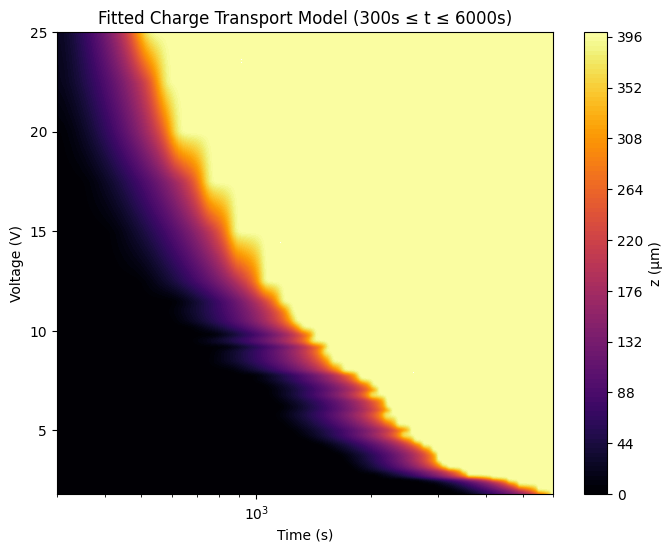

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import gaussian_filter

# **1단계: fittings.csv 로드 & 보간**
fitting_df = pd.read_csv("fittings.csv")

V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # **cm² → µm² 변환**

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 피팅 데이터 생성**
L = 400  # μm
t_grid = np.linspace(300, 6000, 400)  # **📌 점 개수를 200 → 400개로 증가**
V_grid = np.linspace(min(V_values), max(V_values), 400)

V_list, t_list, z_list = [], [], []

for V, t0, mu in zip(V_values, t0_values, mu_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)  # **0~400 μm로 클리핑**

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 2D Grid 보간**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = griddata((t_list, V_list), z_list, (T_grid, V_grid), method='linear')  # 📌 **cubic → linear**

# **4단계: Gaussian 필터로 smoothing**
Z_grid = gaussian_filter(Z_grid, sigma=1.5)  # **📌 스무딩 적용**

# **5단계: 컬러맵 그리기**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (μm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model (300s ≤ t ≤ 6000s)")
plt.xlim(300, 6000)  # 📌 x축 범위 제한
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import gaussian_filter

# **1단계: fittings.csv 로드 & 보간**
fitting_df = pd.read_csv("fittings.csv")

V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # **cm² → µm² 변환**

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  # μm

V_list, t_list, z_list = [], [], []

for V, t0, mu in zip(V_values, t0_values, mu_values):
    # **적응형 t_grid 생성**
    t1 = t0 + L**2 / (2 * V * mu)  # z = L에 도달하는 시간
    t_moving = np.linspace(t0, t1, 200)  # 이동 중 구간을 촘촘하게
    t_later = np.linspace(t1, 6000, 50)  # 이후 구간을 듬성듬성

    t_grid = np.concatenate(([0], [t0], t_moving, t_later))  # 초기값 포함

    # **이온 이동 모델 적용**
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)  # **0~400 μm로 클리핑**

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 2D Grid 보간**
T_grid, V_grid = np.meshgrid(np.logspace(np.log10(300), np.log10(6000), 100), np.linspace(min(V_values), max(V_values), 100))
Z_grid = griddata((t_list, V_list), z_list, (T_grid, V_grid), method='linear')

# **4단계: Gaussian 필터로 smoothing**
Z_grid = gaussian_filter(Z_grid, sigma=1.5)

# **5단계: 컬러맵 그리기**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (μm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model")
plt.xlim(300, 6000)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
for V, t0, mu in zip(V_values, t0_values, mu_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **5단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# plt.xscale("log")
plt.yscale("log")
plt.colorbar(c, label="z (μm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model (Fixed RBF Interpolation)")
plt.xlim(300, 6000)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **5단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (μm)")

# **8단계: t0 및 t_f 값 추가**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 1000)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export.csv", index=False)

# **4단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)


# **5단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)
cmap_main = plt.get_cmap("inferno")  # 기존 컬러맵
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)
# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# **4단계: 컨투어 라인 추가 (z=0 강조)**
contour_levels = [5, 50, 100, 200, 300]
# plt.contour(T_grid, V_grid, Z_grid, levels=contour_levels, colors="white", linewidths=0.8)


plt.yscale("log")
plt.colorbar(c, label="z (μm)")

# **8단계: t0 및 t_f 값 추가**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: RBF 보간**
interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="linear",  # linear로 변경하여 부드러운 변화
    epsilon=500  # 적절한 smoothing (데이터에 따라 조정 가능)
)

# **4단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **5단계: Gaussian 필터 적용하여 부드럽게**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.5)

# **6단계: 컬러맵 설정**
cmap = plt.get_cmap("plasma")  
norm = colors.Normalize(vmin=0, vmax=400)

# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=cmap, norm=norm)

# **8단계: t0 및 t_f 값 추가**
plt.scatter(t0_values, V_values, color="white", marker="o", edgecolors="none", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", edgecolors="none", label="t_f values")  # 파란색 X

plt.xscale("log")
plt.colorbar(c, label="z (μm)")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # 보간 없이 원래 V 값만 사용

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)


# **4단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]
# **3단계: 데이터 CSV로 저장**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export2.csv", index=False)

# **5단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **6단계: 보간된 Grid 생성 (V 값 보간 없이 원래 값만 사용)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **7단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **8단계: 컬러맵 설정**
cmap_main = plt.get_cmap("inferno")  # 기존 컬러맵
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **9단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **10단계: 로그 스케일, 컬러바, t0 및 t_f 값 추가**
plt.yscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings_filled.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # 보간 없이 원래 V 값만 사용

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4단계: 중복 제거 후 데이터 저장**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export3.csv", index=False)

# **5단계: t0 및 t_f 값 저장 (원래 주어진 V에 대해서만)**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_values, "t0 (s)": t0_values, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export.csv", index=False)

# **6단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **7단계: 보간된 Grid 생성 (V 값 보간 없이 원래 값만 사용)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **8단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **9단계: 컬러맵 설정**
cmap_main = plt.get_cmap("inferno")  # 기존 컬러맵
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **10단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **11단계: 로그 스케일, 컬러바, t0 및 t_f 값 추가**
plt.yscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2단계: V 범위에 따라 새로운 V_fine 생성**
V_low = np.arange(1, 3, 0.1)  # 3V 미만: 0.1V 간격
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V 이상: 0.25V 간격
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V 이상 11.5V 미만: 기존 데이터 유지

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3단계: t0와 mu의 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4단계: t_f 및 z 계산**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5단계: 중복 제거 및 데이터 저장**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export4.csv", index=False)

# **6단계: t0 및 t_f 값 저장**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export4.csv", index=False)

# **7단계: Grid 생성 및 플로팅**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2단계: V 범위에 따라 새로운 V_fine 생성**
V_low = np.arange(1, 3, 0.1)  # 3V 미만: 0.1V 간격
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V 이상: 0.25V 간격
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V 이상 11.5V 미만: 기존 데이터 유지

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3단계: t0와 mu의 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4단계: t_f 및 z 계산**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 1000)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5단계: 중복 제거 및 데이터 저장**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export5.csv", index=False)

# **6단계: t0 및 t_f 값 저장**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export5.csv", index=False)

# **7단계: Grid 생성 및 플로팅**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import csv

def interpolate_color(start, end, steps):
    """start에서 end로 선형 보간된 RGB 값을 생성"""
    return np.linspace(start, end, steps, dtype=int)

# 색상 변환 구간 설정
color_stops = [
    (255, 0, 0),   # 빨강
    (255, 255, 0), # 노랑
    (0, 255, 0),   # 초록
    (0, 255, 255), # 시안
    (0, 0, 255)    # 파랑
]

# 4개의 구간으로 255개 점을 균등 분배
num_steps = [11, 11, 11, 11]  # 총 255개가 되도록 조정

# 보간된 색상 리스트 생성
colors = []
for i in range(len(color_stops) - 1):
    start, end = color_stops[i], color_stops[i+1]
    interpolated = interpolate_color(start, end, num_steps[i])
    colors.extend(interpolated[:-1])  # 중복 방지를 위해 마지막 값 제외

# 마지막 색상을 추가하여 255개 맞추기
colors.append(color_stops[-1])

# 배열을 리스트로 변환
colors = [tuple(color) for color in colors]

# CSV 파일로 저장
csv_filename = "colors2.csv"
with open(csv_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["R", "G", "B"])  # 헤더 작성
    writer.writerows(colors)  # 데이터 작성

print(f"CSV 파일 '{csv_filename}' 저장 완료! (총 {len(colors)}개)")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# 가우시안 함수 정의
def gaussian(x, mu=0, sigma=1, a=1):
    #return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return 1/x**2/30
    
# x 범위 설정
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# 컬러맵 설정 (회색 그라데이션)
cmap = cm.Greys  # 연한 회색 -> 진한 회색 (반전된 Greys 컬러맵)
norm = Normalize(vmin=0, vmax=1)  # 정규화

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 4))

# 그라데이션 채우기
for i in range(len(x) - 1):
    ax.fill_between(
        [x[i], x[i+1]],  # x 구간
        [y[i], y[i+1]],  # 상단 경계
        color=cmap(norm(y[i]))  # y 값에 따라 색상 적용
    )

# 축 설정
ax.set_xlim(-3, 3)
ax.set_ylim(0, 1.1)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("Gaussian Function with Gradient Shading")

plt.show()
plt.savefig("output.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 가우시안 함수 정의
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x 범위 설정
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# 이미지용 그리드 생성
X, Y = np.meshgrid(x, np.linspace(0, 1, 256))  # y 방향 그리드
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # 각 x에서 가우시안의 최대값

# ✅ 0 ~ 1 선형 스케일링 적용 (for문 없이 전체 계산)
alpha_values = np.clip(Y / Y_max, 0, 1)  # 0~1 사이로 정규화
alpha_values[Y > Y_max] = 0  # 가우시안 영역 바깥은 0 (완전 투명)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # 투명도 행렬
    extent=[-3, 3, 0, 1],  # x와 y의 범위
    origin="lower",
    cmap="Greys_r",  # 회색 그라데이션
    aspect="auto"
)

# ✅ 축과 라벨 숨김 (외곽선 제거)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ✅ 배경이 투명한 PNG로 저장
plt.savefig("gaussian_gradient_linear.png", transparent=True, dpi=300)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 가우시안 함수 정의
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x 범위 설정
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# 이미지용 그리드 생성
X, Y = np.meshgrid(x, np.linspace(-0.1, 1, 256))  # ✅ y 범위 (-0.1 ~ 1)
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # 각 x에서 가우시안의 최대값

# ✅ 색 변화 적용 (y = -0.1에서 연한색 → y = 0에서 진한색 → y = f(x)에서 다시 연한색)
alpha_values = np.zeros_like(Y)

# 🎯 1. x축 위 (y = 0 ~ f(x)): 중간에서 진하게, 위로 갈수록 연하게
mask_upper = (Y >= 0) & (Y <= Y_max)
alpha_values[mask_upper] = 0.2 + 0.6 * np.abs(1 - 2 * Y[mask_upper] / Y_max[mask_upper])  # 중간이 가장 진함

# 🎯 2. x축 아래 (y = -0.1 ~ 0): 일정한 색 (연한 회색, 예: 0.6)
mask_lower = (Y < 0)
alpha_values[mask_lower] = 0.6  

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # 투명도 행렬
    extent=[-3, 3, -0.1, 1],  # ✅ y 범위 (-0.1 ~ 1)
    origin="lower",
    cmap="Greys",  # 회색 그라데이션
    aspect="auto"
)

# ✅ 축과 라벨 숨김 (외곽선 제거)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ✅ 배경이 투명한 PNG로 저장
plt.savefig("gaussian_gradient_symmetric.png", transparent=True, dpi=300)

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# 데이터 로드
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# V 범위 설정
V_low = np.arange(1, 3, 0.1)
V_high = np.arange(11.5, max(V_values) + 5, 0.25)
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]
V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# 보간
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# Vt 그리드 설정
Vt_min, Vt_max = 1e3, 1e4  # Vt의 최소, 최대 범위
Vt_grid = np.logspace(np.log10(Vt_min), np.log10(Vt_max), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []
z_map = {}
dzdt_map = {}

L = 400

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)
    
    t_values = t0 + Vt_grid / V  # Vt = V * (t - t0) 정의
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)  # dz/dt 계산
    
    V_list.extend([V] * len(Vt_grid))
    Vt_list.extend(Vt_grid)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)
    
    z_map[V] = interp1d(Vt_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")
    dzdt_map[V] = interp1d(Vt_grid, dzdt_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# 데이터 저장
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V⋅s)": Vt_list, "z (μm)": z_list, "dz/dt (μm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# Grid 생성
Vt_mesh, V_mesh = np.meshgrid(Vt_grid, V_fine)
Z_grid = np.zeros_like(Vt_mesh)
DZDT_grid = np.zeros_like(Vt_mesh)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](Vt_grid)
    DZDT_grid[i, :] = dzdt_map[V](Vt_grid)

Z_grid = gaussian_filter(np.clip(Z_grid, 0, 400), sigma=0.5)
DZDT_grid = gaussian_filter(DZDT_grid, sigma=0.5)

# 플로팅
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# 첫 번째 컬러맵 (Vt - z)
c1 = axes[0].contourf(Vt_mesh, V_mesh, Z_grid, levels=100, cmap=custom_cmap)
axes[0].set_xscale("log")
axes[0].set_xlabel("Vt (V⋅s)")
axes[0].set_ylabel("Voltage (V)")
axes[0].set_title("Voltage - Vt - z")
fig.colorbar(c1, ax=axes[0], label="z (μm)")

# 두 번째 컬러맵 (Vt - dz/dt)
c2 = axes[1].contourf(Vt_mesh, V_mesh, DZDT_grid, levels=100, cmap=custom_cmap)
axes[1].set_xscale("log")
axes[1].set_xlabel("Vt (V⋅s)")
axes[1].set_ylabel("Voltage (V)")
axes[1].set_title("Voltage - Vt - dz/dt")
fig.colorbar(c2, ax=axes[1], label="dz/dt (μm/s)")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2단계: V 범위에 따라 새로운 V_fine 생성**
V_low = np.arange(1, 3, 0.1)  # 3V 미만: 0.1V 간격
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V 이상: 0.25V 간격
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V 이상 11.5V 미만: 기존 데이터 유지

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3단계: t0와 mu의 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4단계: Vt 및 z 계산**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []

def compute_z(V, t0, mu, t_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)
    return z_values, dzdt_values

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    Vt_values = V * (t_grid - t0)
    valid_mask = Vt_values > 0
    Vt_values = Vt_values[valid_mask]
    t_valid = t_grid[valid_mask]
    
    z_values, dzdt_values = compute_z(V, t0, mu, t_valid)
    
    V_list.extend([V] * len(Vt_values))
    Vt_list.extend(Vt_values)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)

# **5단계: 데이터 저장**
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V⋅s)": Vt_list, "z (μm)": z_list, "dz/dt (μm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# **6단계: Grid 생성 및 플로팅**
Vt_grid = np.logspace(np.log10(min(Vt_list)), np.log10(max(Vt_list)), 400)
V_grid = np.unique(V_list)
Z_grid = np.zeros((len(V_grid), len(Vt_grid)))
dZdt_grid = np.zeros_like(Z_grid)

for i, V in enumerate(V_grid):
    mask = np.array(V_list) == V
    interp_z = interp1d(np.array(Vt_list)[mask], np.array(z_list)[mask], kind="linear", fill_value="extrapolate")
    interp_dzdt = interp1d(np.array(Vt_list)[mask], np.array(dzdt_list)[mask], kind="linear", fill_value="extrapolate")
    Z_grid[i, :] = interp_z(Vt_grid)
    dZdt_grid[i, :] = interp_dzdt(Vt_grid)

Z_grid = gaussian_filter(Z_grid, sigma=0.5)
dZdt_grid = gaussian_filter(dZdt_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c1 = plt.contourf(Vt_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c1, label="z (μm)")
plt.xlabel("Vt (V⋅s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: z (μm)")
plt.show()

plt.figure(figsize=(8, 6))
c2 = plt.contourf(Vt_grid, V_grid, dZdt_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c2, label="dz/dt (μm/s)")
plt.xlabel("Vt (V⋅s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: dz/dt (μm/s)")
plt.show()


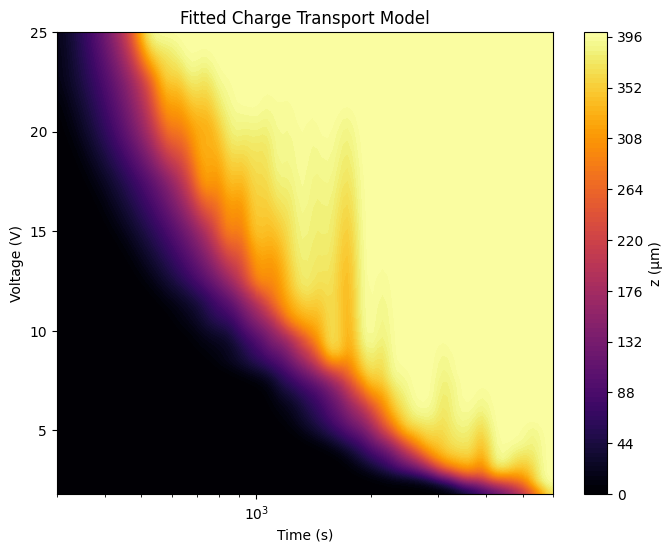

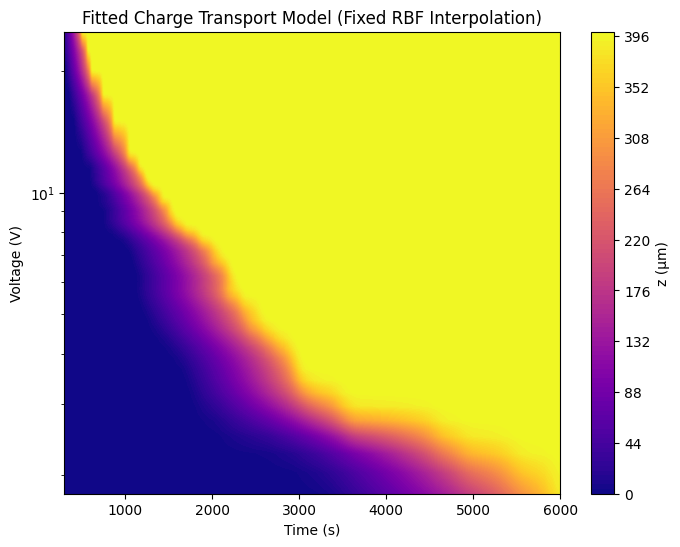

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
for V, t0, mu in zip(V_values, t0_values, mu_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **5단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# plt.xscale("log")
plt.yscale("log")
plt.colorbar(c, label="z (μm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model (Fixed RBF Interpolation)")
plt.xlim(300, 6000)
plt.show()


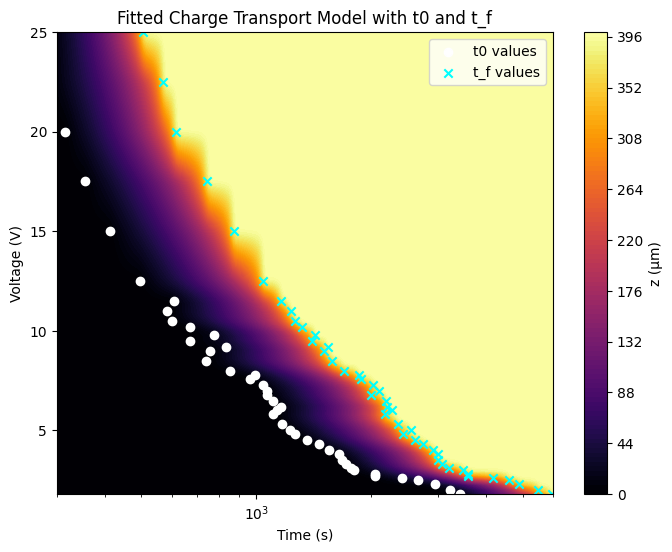

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **5단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (μm)")

# **8단계: t0 및 t_f 값 추가**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 1000)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export.csv", index=False)

# **4단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)


# **5단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)
cmap_main = plt.get_cmap("inferno")  # 기존 컬러맵
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)
# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# **4단계: 컨투어 라인 추가 (z=0 강조)**
contour_levels = [5, 50, 100, 200, 300]
# plt.contour(T_grid, V_grid, Z_grid, levels=contour_levels, colors="white", linewidths=0.8)


plt.yscale("log")
plt.colorbar(c, label="z (μm)")

# **8단계: t0 및 t_f 값 추가**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


PermissionError: [Errno 13] Permission denied: 'data_export.csv'

C:\Users\chemi\AppData\Local\Temp\ipykernel_16532\479902461.py:68: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(t_f_values, V_values, color="cyan", marker="x", edgecolors="none", label="t_f values")  # 파란색 X


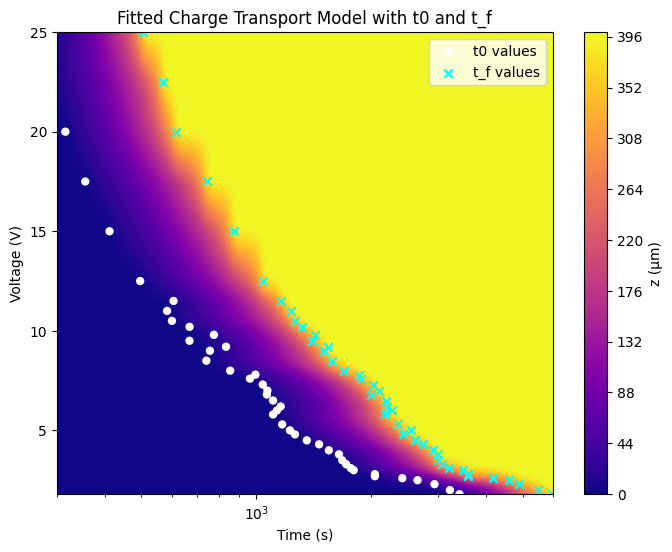

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: RBF 보간**
interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="linear",  # linear로 변경하여 부드러운 변화
    epsilon=500  # 적절한 smoothing (데이터에 따라 조정 가능)
)

# **4단계: 보간된 Grid 생성**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **5단계: Gaussian 필터 적용하여 부드럽게**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.5)

# **6단계: 컬러맵 설정**
cmap = plt.get_cmap("plasma")  
norm = colors.Normalize(vmin=0, vmax=400)

# **7단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=cmap, norm=norm)

# **8단계: t0 및 t_f 값 추가**
plt.scatter(t0_values, V_values, color="white", marker="o", edgecolors="none", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", edgecolors="none", label="t_f values")  # 파란색 X

plt.xscale("log")
plt.colorbar(c, label="z (μm)")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


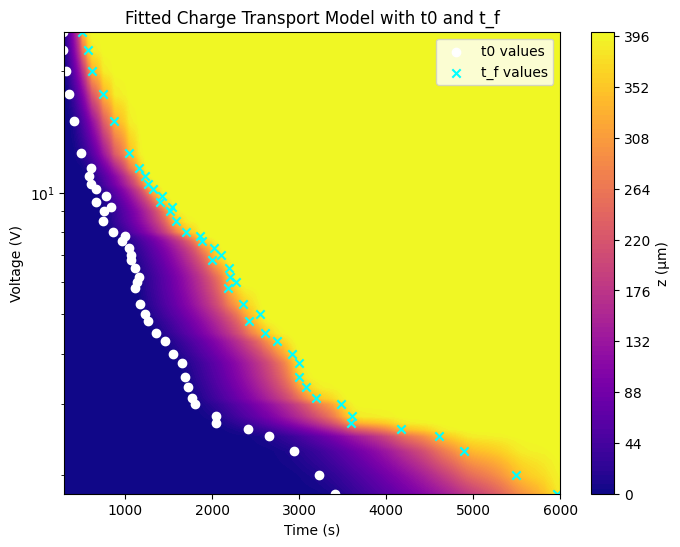

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # 보간 없이 원래 V 값만 사용

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)


# **4단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]
# **3단계: 데이터 CSV로 저장**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export2.csv", index=False)

# **5단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **6단계: 보간된 Grid 생성 (V 값 보간 없이 원래 값만 사용)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **7단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **8단계: 컬러맵 설정**
cmap_main = plt.get_cmap("inferno")  # 기존 컬러맵
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **9단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **10단계: 로그 스케일, 컬러바, t0 및 t_f 값 추가**
plt.yscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


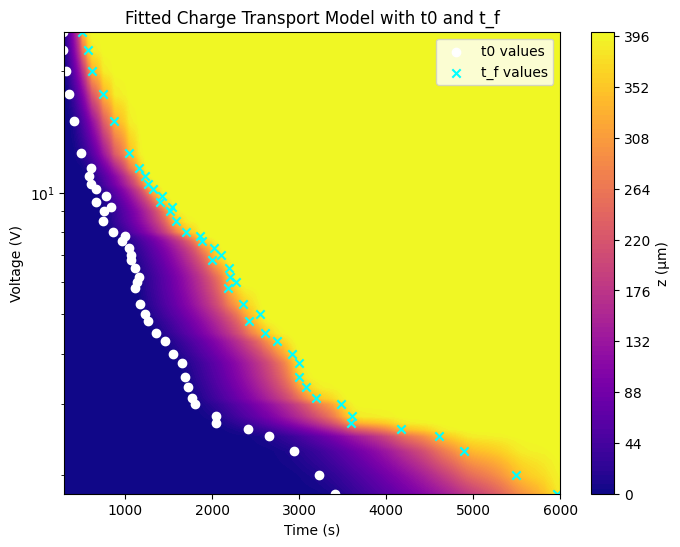

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings_filled.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2단계: 데이터 생성**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # 보간 없이 원래 V 값만 사용

V_list, t_list, z_list = [], [], []
t_f_values = []  # 최종 도달 시간 저장

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f 계산
    t_f_values.append(t_f)  # 리스트에 저장

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3단계: 중복 데이터 제거**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4단계: 중복 제거 후 데이터 저장**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export3.csv", index=False)

# **5단계: t0 및 t_f 값 저장 (원래 주어진 V에 대해서만)**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_values, "t0 (s)": t0_values, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export.csv", index=False)

# **6단계: RBF 보간**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # 데이터 기반 epsilon 설정
)

# **7단계: 보간된 Grid 생성 (V 값 보간 없이 원래 값만 사용)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **8단계: Gaussian 필터 적용**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **9단계: 컬러맵 설정**
cmap_main = plt.get_cmap("inferno")  # 기존 컬러맵
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **10단계: 그래프 출력**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **11단계: 로그 스케일, 컬러바, t0 및 t_f 값 추가**
plt.yscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # 흰색 원
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # 파란색 X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


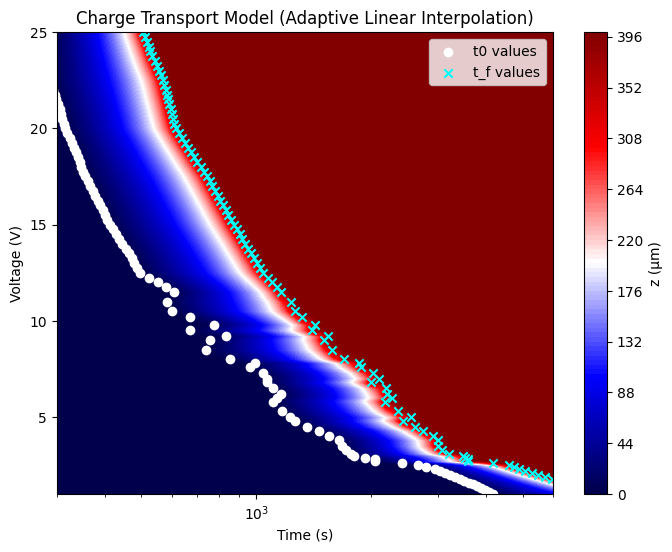

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2단계: V 범위에 따라 새로운 V_fine 생성**
V_low = np.arange(1, 3, 0.1)  # 3V 미만: 0.1V 간격
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V 이상: 0.25V 간격
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V 이상 11.5V 미만: 기존 데이터 유지

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3단계: t0와 mu의 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4단계: t_f 및 z 계산**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5단계: 중복 제거 및 데이터 저장**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export4.csv", index=False)

# **6단계: t0 및 t_f 값 저장**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export4.csv", index=False)

# **7단계: Grid 생성 및 플로팅**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()


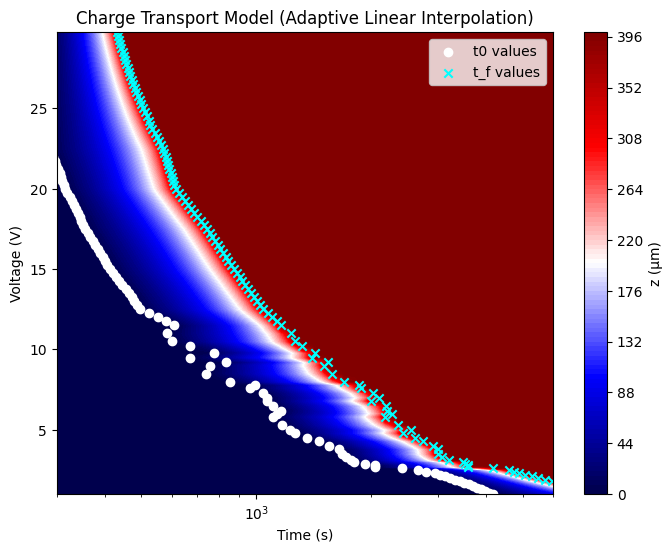

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2단계: V 범위에 따라 새로운 V_fine 생성**
V_low = np.arange(1, 3, 0.1)  # 3V 미만: 0.1V 간격
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V 이상: 0.25V 간격
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V 이상 11.5V 미만: 기존 데이터 유지

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3단계: t0와 mu의 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4단계: t_f 및 z 계산**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 1000)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5단계: 중복 제거 및 데이터 저장**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (μm)": z_list})
export_df.to_csv("data_export5.csv", index=False)

# **6단계: t0 및 t_f 값 저장**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export5.csv", index=False)

# **7단계: Grid 생성 및 플로팅**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (μm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()

In [52]:
import numpy as np
import csv

def interpolate_color(start, end, steps):
    """start에서 end로 선형 보간된 RGB 값을 생성"""
    return np.linspace(start, end, steps, dtype=int)

# 색상 변환 구간 설정
color_stops = [
    (255, 0, 0),   # 빨강
    (255, 255, 0), # 노랑
    (0, 255, 0),   # 초록
    (0, 255, 255), # 시안
    (0, 0, 255)    # 파랑
]

# 4개의 구간으로 255개 점을 균등 분배
num_steps = [11, 11, 11, 11]  # 총 255개가 되도록 조정

# 보간된 색상 리스트 생성
colors = []
for i in range(len(color_stops) - 1):
    start, end = color_stops[i], color_stops[i+1]
    interpolated = interpolate_color(start, end, num_steps[i])
    colors.extend(interpolated[:-1])  # 중복 방지를 위해 마지막 값 제외

# 마지막 색상을 추가하여 255개 맞추기
colors.append(color_stops[-1])

# 배열을 리스트로 변환
colors = [tuple(color) for color in colors]

# CSV 파일로 저장
csv_filename = "colors2.csv"
with open(csv_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["R", "G", "B"])  # 헤더 작성
    writer.writerows(colors)  # 데이터 작성

print(f"CSV 파일 '{csv_filename}' 저장 완료! (총 {len(colors)}개)")


CSV 파일 'colors2.csv' 저장 완료! (총 41개)


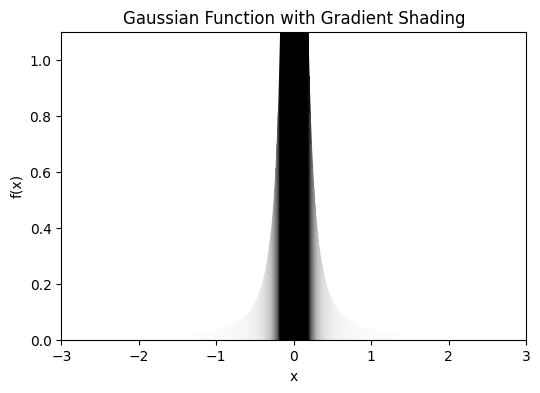

<Figure size 640x480 with 0 Axes>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# 가우시안 함수 정의
def gaussian(x, mu=0, sigma=1, a=1):
    #return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return 1/x**2/30
    
# x 범위 설정
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# 컬러맵 설정 (회색 그라데이션)
cmap = cm.Greys  # 연한 회색 -> 진한 회색 (반전된 Greys 컬러맵)
norm = Normalize(vmin=0, vmax=1)  # 정규화

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 4))

# 그라데이션 채우기
for i in range(len(x) - 1):
    ax.fill_between(
        [x[i], x[i+1]],  # x 구간
        [y[i], y[i+1]],  # 상단 경계
        color=cmap(norm(y[i]))  # y 값에 따라 색상 적용
    )

# 축 설정
ax.set_xlim(-3, 3)
ax.set_ylim(0, 1.1)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("Gaussian Function with Gradient Shading")

plt.show()
plt.savefig("output.png")


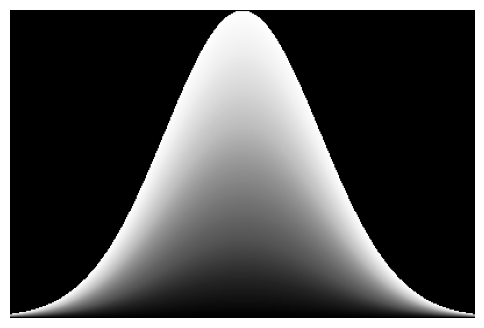

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 가우시안 함수 정의
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x 범위 설정
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# 이미지용 그리드 생성
X, Y = np.meshgrid(x, np.linspace(0, 1, 256))  # y 방향 그리드
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # 각 x에서 가우시안의 최대값

# ✅ 0 ~ 1 선형 스케일링 적용 (for문 없이 전체 계산)
alpha_values = np.clip(Y / Y_max, 0, 1)  # 0~1 사이로 정규화
alpha_values[Y > Y_max] = 0  # 가우시안 영역 바깥은 0 (완전 투명)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # 투명도 행렬
    extent=[-3, 3, 0, 1],  # x와 y의 범위
    origin="lower",
    cmap="Greys_r",  # 회색 그라데이션
    aspect="auto"
)

# ✅ 축과 라벨 숨김 (외곽선 제거)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ✅ 배경이 투명한 PNG로 저장
plt.savefig("gaussian_gradient_linear.png", transparent=True, dpi=300)

plt.show()

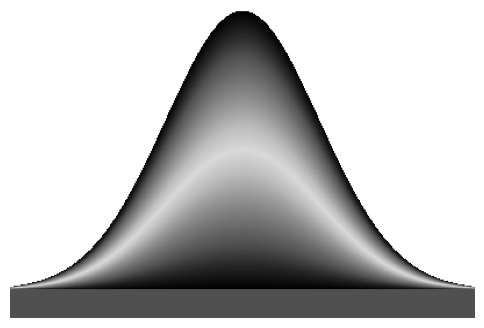

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# 가우시안 함수 정의
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x 범위 설정
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# 이미지용 그리드 생성
X, Y = np.meshgrid(x, np.linspace(-0.1, 1, 256))  # ✅ y 범위 (-0.1 ~ 1)
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # 각 x에서 가우시안의 최대값

# ✅ 색 변화 적용 (y = -0.1에서 연한색 → y = 0에서 진한색 → y = f(x)에서 다시 연한색)
alpha_values = np.zeros_like(Y)

# 🎯 1. x축 위 (y = 0 ~ f(x)): 중간에서 진하게, 위로 갈수록 연하게
mask_upper = (Y >= 0) & (Y <= Y_max)
alpha_values[mask_upper] = 0.2 + 0.6 * np.abs(1 - 2 * Y[mask_upper] / Y_max[mask_upper])  # 중간이 가장 진함

# 🎯 2. x축 아래 (y = -0.1 ~ 0): 일정한 색 (연한 회색, 예: 0.6)
mask_lower = (Y < 0)
alpha_values[mask_lower] = 0.6  

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # 투명도 행렬
    extent=[-3, 3, -0.1, 1],  # ✅ y 범위 (-0.1 ~ 1)
    origin="lower",
    cmap="Greys",  # 회색 그라데이션
    aspect="auto"
)

# ✅ 축과 라벨 숨김 (외곽선 제거)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ✅ 배경이 투명한 PNG로 저장
plt.savefig("gaussian_gradient_symmetric.png", transparent=True, dpi=300)

plt.show()


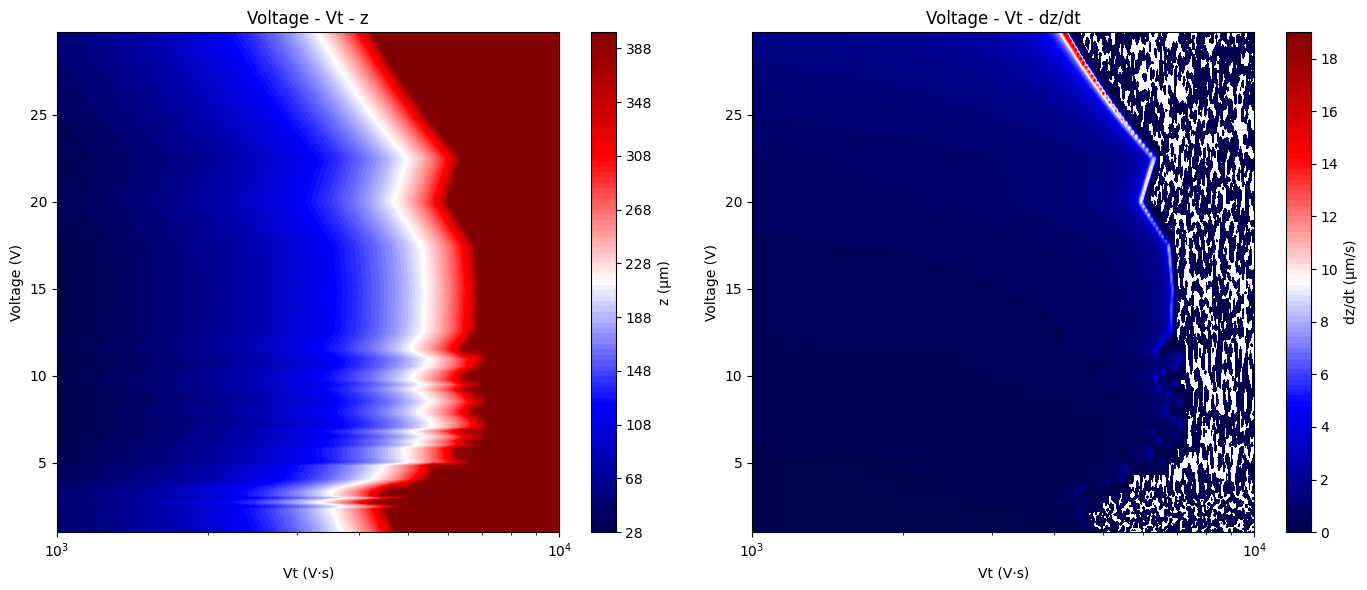

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# 데이터 로드
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# V 범위 설정
V_low = np.arange(1, 3, 0.1)
V_high = np.arange(11.5, max(V_values) + 5, 0.25)
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]
V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# 보간
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# Vt 그리드 설정
Vt_min, Vt_max = 1e3, 1e4  # Vt의 최소, 최대 범위
Vt_grid = np.logspace(np.log10(Vt_min), np.log10(Vt_max), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []
z_map = {}
dzdt_map = {}

L = 400

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)
    
    t_values = t0 + Vt_grid / V  # Vt = V * (t - t0) 정의
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)  # dz/dt 계산
    
    V_list.extend([V] * len(Vt_grid))
    Vt_list.extend(Vt_grid)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)
    
    z_map[V] = interp1d(Vt_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")
    dzdt_map[V] = interp1d(Vt_grid, dzdt_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# 데이터 저장
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V⋅s)": Vt_list, "z (μm)": z_list, "dz/dt (μm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# Grid 생성
Vt_mesh, V_mesh = np.meshgrid(Vt_grid, V_fine)
Z_grid = np.zeros_like(Vt_mesh)
DZDT_grid = np.zeros_like(Vt_mesh)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](Vt_grid)
    DZDT_grid[i, :] = dzdt_map[V](Vt_grid)

Z_grid = gaussian_filter(np.clip(Z_grid, 0, 400), sigma=0.5)
DZDT_grid = gaussian_filter(DZDT_grid, sigma=0.5)

# 플로팅
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# 첫 번째 컬러맵 (Vt - z)
c1 = axes[0].contourf(Vt_mesh, V_mesh, Z_grid, levels=100, cmap=custom_cmap)
axes[0].set_xscale("log")
axes[0].set_xlabel("Vt (V⋅s)")
axes[0].set_ylabel("Voltage (V)")
axes[0].set_title("Voltage - Vt - z")
fig.colorbar(c1, ax=axes[0], label="z (μm)")

# 두 번째 컬러맵 (Vt - dz/dt)
c2 = axes[1].contourf(Vt_mesh, V_mesh, DZDT_grid, levels=100, cmap=custom_cmap)
axes[1].set_xscale("log")
axes[1].set_xlabel("Vt (V⋅s)")
axes[1].set_ylabel("Voltage (V)")
axes[1].set_title("Voltage - Vt - dz/dt")
fig.colorbar(c2, ax=axes[1], label="dz/dt (μm/s)")

plt.tight_layout()
plt.show()

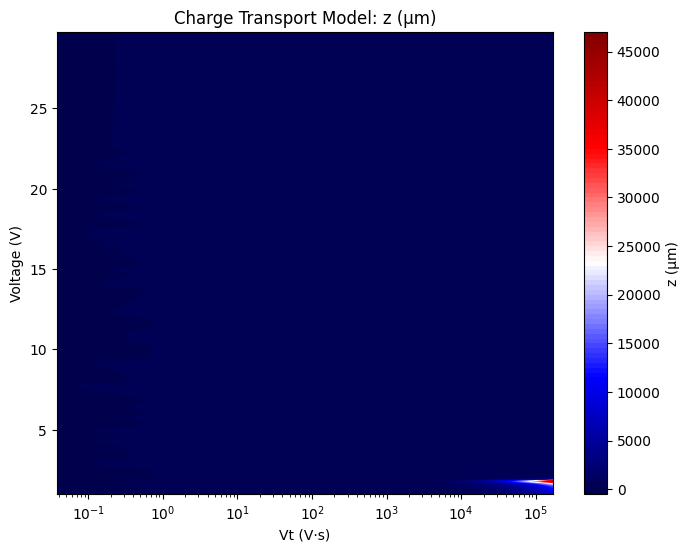

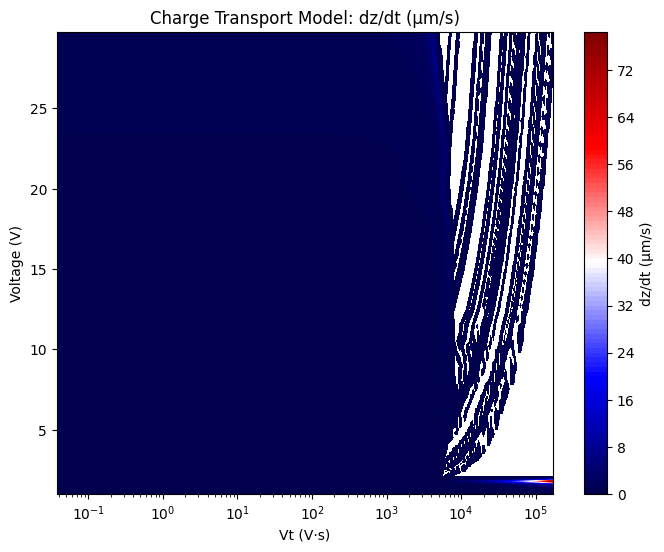

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1단계: 데이터 로드**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm² → μm² 변환

# **2단계: V 범위에 따라 새로운 V_fine 생성**
V_low = np.arange(1, 3, 0.1)  # 3V 미만: 0.1V 간격
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V 이상: 0.25V 간격
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V 이상 11.5V 미만: 기존 데이터 유지

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3단계: t0와 mu의 보간**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4단계: Vt 및 z 계산**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []

def compute_z(V, t0, mu, t_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)
    return z_values, dzdt_values

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    Vt_values = V * (t_grid - t0)
    valid_mask = Vt_values > 0
    Vt_values = Vt_values[valid_mask]
    t_valid = t_grid[valid_mask]
    
    z_values, dzdt_values = compute_z(V, t0, mu, t_valid)
    
    V_list.extend([V] * len(Vt_values))
    Vt_list.extend(Vt_values)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)

# **5단계: 데이터 저장**
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V⋅s)": Vt_list, "z (μm)": z_list, "dz/dt (μm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# **6단계: Grid 생성 및 플로팅**
Vt_grid = np.logspace(np.log10(min(Vt_list)), np.log10(max(Vt_list)), 400)
V_grid = np.unique(V_list)
Z_grid = np.zeros((len(V_grid), len(Vt_grid)))
dZdt_grid = np.zeros_like(Z_grid)

for i, V in enumerate(V_grid):
    mask = np.array(V_list) == V
    interp_z = interp1d(np.array(Vt_list)[mask], np.array(z_list)[mask], kind="linear", fill_value="extrapolate")
    interp_dzdt = interp1d(np.array(Vt_list)[mask], np.array(dzdt_list)[mask], kind="linear", fill_value="extrapolate")
    Z_grid[i, :] = interp_z(Vt_grid)
    dZdt_grid[i, :] = interp_dzdt(Vt_grid)

Z_grid = gaussian_filter(Z_grid, sigma=0.5)
dZdt_grid = gaussian_filter(dZdt_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c1 = plt.contourf(Vt_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c1, label="z (μm)")
plt.xlabel("Vt (V⋅s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: z (μm)")
plt.show()

plt.figure(figsize=(8, 6))
c2 = plt.contourf(Vt_grid, V_grid, dZdt_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c2, label="dz/dt (μm/s)")
plt.xlabel("Vt (V⋅s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: dz/dt (μm/s)")
plt.show()
